In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [2]:
N = 1000
size = 64
labels = np.random.randint(1, 2, size = N)
imgs = np.zeros((size, size, N))




In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse=False, size=size,num_big_blobs=4)
    imgs[:,:,i] = x

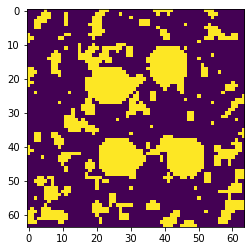

In [4]:
plt.imshow(imgs[:,:,1])

In [5]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)
model = tf.keras.models.load_model("models\model40_3l_3c")

for img in range(N):
    heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -6, 1)
    heatmaps[:,:,img] /= 255
    #heatmaps[:,:,img] = minmax_scale(heatmaps[:,:,img])



In [6]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [7]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

68833

In [8]:
num_blobs//imgs.shape[-1]

68

In [9]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = np.mean((heatmaps[:,:,img] * x))
            scores[i] = img_score
            if img_score > img_highscore:
                img_highscore = img_score
            i += 1
    highscores.append(img_highscore)
        

In [10]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(1019,)

In [11]:
blob_areas = []
blob_eccentricities = []
blob_eq_areas = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    blob_areas += areas.tolist()
    blob_eccentricities += eccentricities.tolist()
    blob_eq_areas += eq_areas.tolist()

blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_areas = np.asarray(blob_eq_areas)
blob_areas.shape

(68833,)

In [12]:
from seaborn import pairplot
data = pd.DataFrame({'Score': scores, 
                        'Area': blob_areas,
                        'Eccentricity': blob_eccentricities,
                        'Cirle area equivalent': blob_eq_areas})

pairplot(data)


KeyboardInterrupt: 

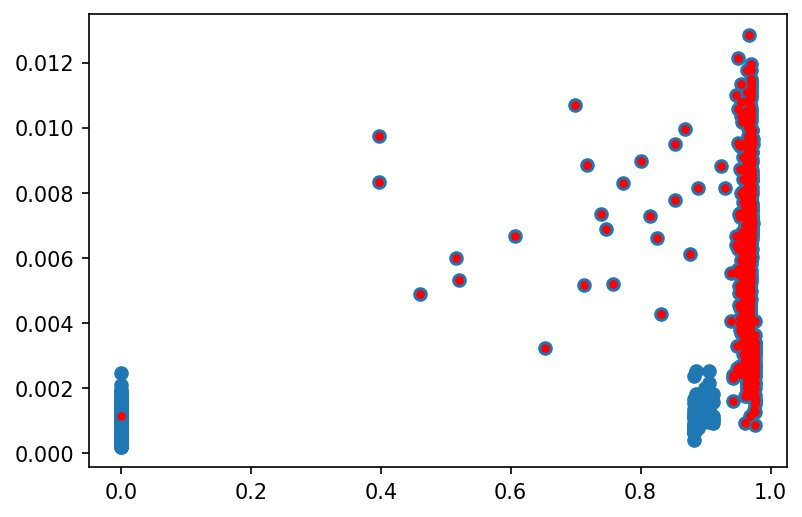

In [12]:
y = scores[ind]
x = blob_eccentricities[ind]
fig= plt.figure()
fig.set_dpi(150)
plt.scatter(blob_eccentricities, scores)
plt.scatter(x,y, s = 10, c = 'r')

0.000557537905328991

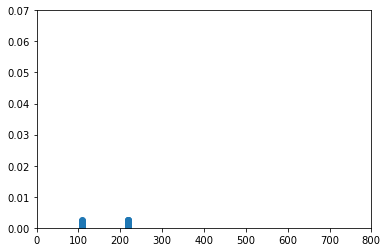

In [13]:
fig = plt.figure()
plt.scatter(np.delete(blob_areas, ind), np.delete(scores, ind))
plt.xlim([0, 800])
plt.ylim([0, 0.07])

np.mean(np.delete(scores, ind))

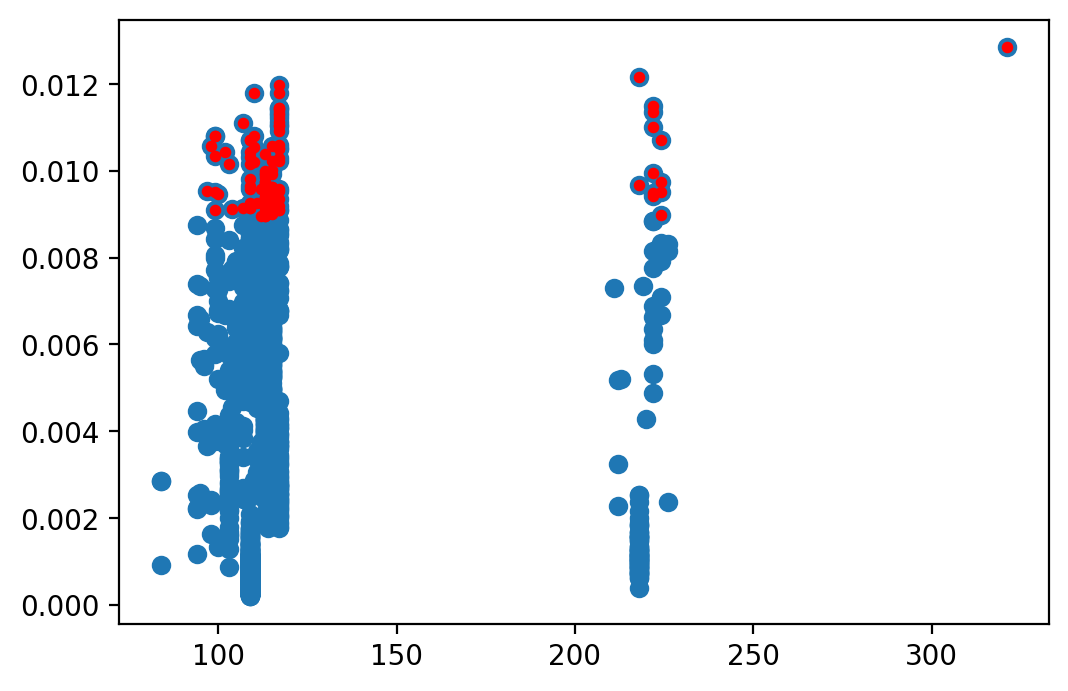

In [14]:
quant = np.quantile(scores, 1 - 1/40)
z = np.where(scores > quant)[0]
y = scores[z]
x = blob_areas[z]
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(blob_areas, scores)
plt.scatter(x,y, s = 10,  c='r')

In [12]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((blob_eccentricities, scores)).T, columns=['eccentricity', ' score'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


In [13]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((blob_areas, blob_eccentricities))
X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [14]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor = regressor.fit(X_train, y_train)

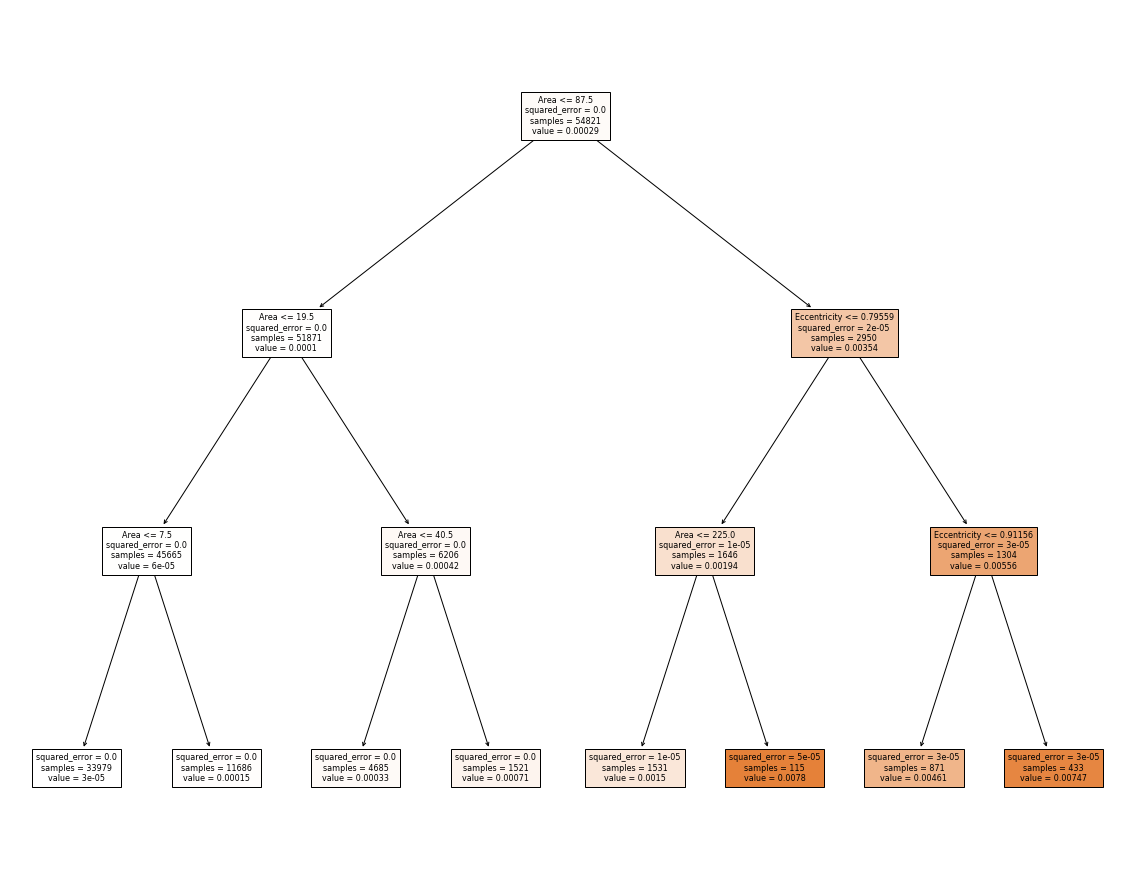

In [15]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,16))
plot_tree(regressor, max_depth=3, feature_names=["Area","Eccentricity"], filled=True, fontsize=8, precision=5)
plt.show()


ValueError: x and y must be the same size

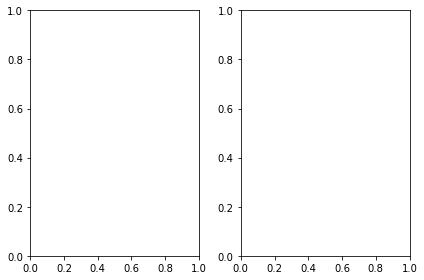

In [30]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
pred = regressor.predict(X_test)
ax[0].scatter(X_test, pred)
ax[0].set_title("Fitted Set")
ax[1].scatter(X_test, y_test)
ax[1].set_title("Test Set")

ValueError: x and y must be the same size

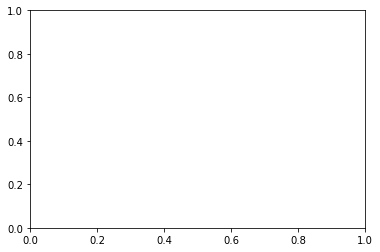

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, pred, c = 'black')

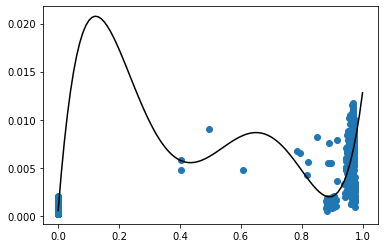

In [26]:
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(X_train.squeeze(), y_train, 5))

#add fitted polynomial line to scatterplot
polyline = np.linspace(0, 1, 100)
plt.scatter(X_train, y_train)
plt.plot(polyline, model(polyline), c = 'black')
plt.show()

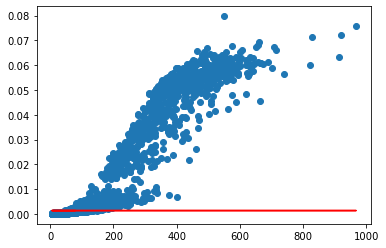

In [285]:
from scipy.optimize import curve_fit
def sigmoid(x, b, a):
    return 1.0/(1.0 + np.exp(-a*(x-b)))
bounds = ([200, 0.], [400, 0.005])
p0 = [300., 0.00001]
popt, pcov = curve_fit(sigmoid, X_train.squeeze() , y_train, method = 'dogbox')
plt.scatter(X_train, y_train)
plt.plot(X_train.squeeze(), sigmoid(X_train.squeeze(), *popt), c = 'r')